In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/Colab Notebooks'

In [1]:
import tqdm
import re

import numpy as np
import seaborn as sns
# !pip install imutils
import imutils
import random
import math

from IPython.display import Image
import matplotlib.cm as cm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D, BatchNormalization,  MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, MobileNet, efficientnet
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# dir = "Colab Notebooks/"
dir = ""
train_dir = dir + "birds315/train/"
test_dir = dir + "birds315/test"
val_dir = dir + "birds315/valid"

In [ ]:
os.listdir(dir + 'birds315')

['EfficientNetB3-birds-98.92.h5', 'test', 'train', 'valid', 'class_dict.csv']

In [ ]:
IMGS = 224
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=float(1. / 255),
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 30,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255, dtype=float)
val_datagen = ImageDataGenerator(rescale=1. / 255, dtype=float)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMGS, IMGS),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMGS, IMGS),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMGS, IMGS),
    batch_size=batch_size,
    class_mode='categorical')

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


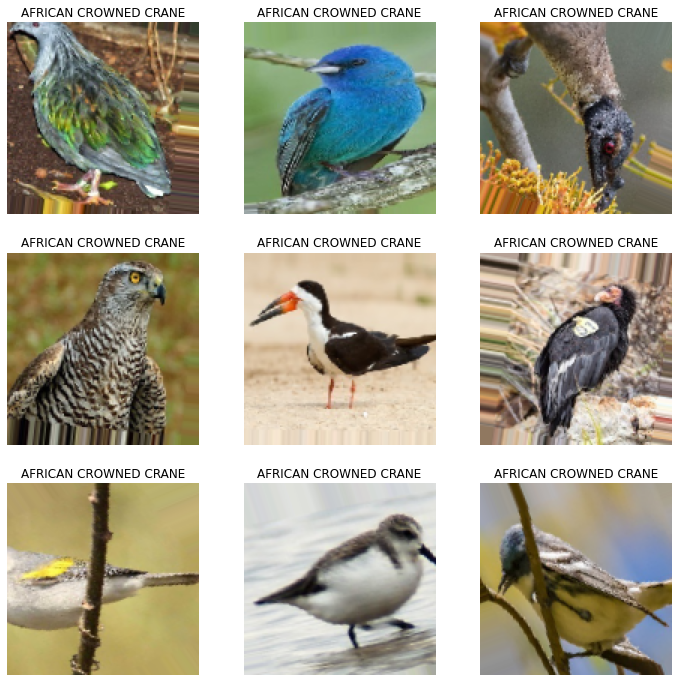

In [ ]:
plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(3,3, i+1)
  image = train_generator[0][0][i]
  img_label = os.path.split(train_generator.filenames[i])[0]
  plt.imshow(image)
  plt.title(img_label)
  plt.axis("off")

In [2]:
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > .95):
            print("Accuracy is High Enough so Stopping Training")
            self.model.stop_training= True

In [3]:
base_model=efficientnet.EfficientNetB3(weights='imagenet', 
                input_shape=(224, 224, 3),
                include_top=False)

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
prv_model = models.load_model(dir+'birds315/EfficientNetB3-birds-98.92.h5')

In [4]:
last = base_model.get_layer('top_activation').output
x = layers.GlobalMaxPooling2D()(last)
x = layers.Dense(256, activation = 'relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
pred = layers.Dense(315, activation = 'sigmoid')(x)

In [5]:
# instantiate a new_model using keras’s Model class
model_eff = Model(inputs=base_model.input, outputs=pred)
# model_eff = Model(base_model.input, pred)

In [6]:
print(model_eff.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
# base_model.trainable = False
for layer in model_eff.layers:
    layer.trainable  = False

In [ ]:
nbr_birds = len(train_generator.class_indices)

In [ ]:
model_eff.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > .95):
            print("Accuracy is High Enough so Stopping Training")
            self.model.stop_training= True
 
history = model_eff.fit(train_generator,
              epochs = 15,
              steps_per_epoch = 350,
              validation_data = validation_generator,
              verbose=1,
              callbacks=[callback]
              )

Epoch 1/5
50/50 [==============================] - 929s 19s/step - loss: 10.5961 - accuracy: 0.0031 - val_loss: 10.6255 - val_accuracy: 0.0032
Epoch 2/5
50/50 [==============================] - 574s 11s/step - loss: 10.5796 - accuracy: 0.0019 - val_loss: 10.6255 - val_accuracy: 0.0032
Epoch 3/5
50/50 [==============================] - 541s 11s/step - loss: 10.6199 - accuracy: 0.0022 - val_loss: 10.6255 - val_accuracy: 0.0032
Epoch 4/5
50/50 [==============================] - 526s 11s/step - loss: 10.6117 - accuracy: 0.0031 - val_loss: 10.6255 - val_accuracy: 0.0032
Epoch 5/5
50/50 [==============================] - 479s 10s/step - loss: 10.7658 - accuracy: 0.0034 - val_loss: 10.6255 - val_accuracy: 0.0032


In [ ]:
# new_model.load_weights(dir+'birds315/EfficientNetB3-birds-98.92.h5')


In [ ]:
scores = model_eff.evaluate(test_generator)
print('Accuracy =',scores[1]*100)

132/132 [==============================] - 333s 2s/step - loss: 11.2070 - accuracy: 0.0032
Accuracy = 0.3174603218212724


In [ ]:
def plot_history(history, desc = ''):
    
    fig = plt.figure(figsize = (18 , 6))
    
    if desc:
        plt.title('{}'.format(desc), fontsize = 16, y = -0.1)

    subplot = (1, 2, 1)
    fig.add_subplot(*subplot)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()
    
    subplot = (1, 2, 2)
    fig.add_subplot(*subplot)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

In [ ]:
# Accuracy and loss plots
plot_history(history)

In [ ]:
y_pred = model_eff.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.round(y_pred), test_generator))

In [ ]:
import math
number_of_test_files = len(test_generator.filenames)
number_of_generator_calls = math.ceil(number_of_test_files / (1.0 * 32)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_generator[i][1]))

In [ ]:
y_pred = np.round(y_pred)
y_pred = y_pred.reshape(-1,)
y_test = test_labels.astype('float')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='',xticklabels = classes, yticklabels = classes)
print('''[‘True Neg’,’False Pos’
,’False Neg’,’True Pos’]''')
plt.show()

In [ ]:
# Display some incorrect and correct classified images
img_path = 'birds315/test/ALBATROSS/1.jpg'
img_arr = cv2.imread(img_path)
# img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
classes = ['NORMAL', 'PNEUMONIA']
img_arr = crop_brain_contour(img_arr, False)
img_arr = cv2.resize(img_arr, (IMGS, IMGS))
plt.imshow(img_arr)
plt.show()
img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
print(classes[int(np.round(model.predict(img_arr)[0][0]))])

In [ ]:
# Read Image as array
def get_img_array(img_path, size):
    img_arr = cv2.imread(img_path)
    img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, (IMGS, IMGS))
    img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
    return img_arr

In [ ]:
# Prepare for gradcam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
img_path = 'birds315/test/ALBATROSS/1.jpg'

In [ ]:
img_array = get_img_array(img_path, size = img_size)
# NORMAL/IM-0147-0001.jpeg
print(img_array.shape)

# # Make model
# model = model_builder(weights="imagenet")
# # Print what the top predicted class is
preds = model.predict(img_array)
# print(preds)
print("Predicted:", classes[int(np.round(model.predict(img_arr)[0][0]))])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
# super imposed heatmap on original image
import tensorflow
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("RdYlGn_r")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.9 + img
superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "grad_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
print("Predicted:", classes[int(np.round(model.predict(img_arr)[0][0]))])
plt.imshow(superimposed_img)
plt.show()
# display(Image(save_path))